In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
#from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
#service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
# setting for jax, if you haven't installed jax, execute the below
# !pip install jax

import jax
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

from qiskit.visualization import plot_histogram


# use Array class provided by qiskit_dynamics for jax
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')

In [34]:
# We truncated the provided hamiltonian into two qubit
import numpy as np

dim = 2

v0 = 4.97e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.85e9
anharm1 = -0.32e9
r1 = 0.26e9

J01 = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**3, dtype=complex)

N0 = np.kron(ident, np.kron(ident, N))
N1 = np.kron(ident,np.kron(N, ident))


a0 = np.kron(ident, np.kron(ident, a))
a1 = np.kron(ident, np.kron(a, ident))


a0dag = np.kron(ident, np.kron(ident, adag))
a1dag = np.kron(ident, np.kron(adag, ident))


static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)


static_ham_full = static_ham0
static_ham_full += static_ham1
static_ham_full +=2 * np.pi * J01 * ((a0 + a0dag) @ (a1 + a1dag))


drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)


eigen_freqs = sorted(np.linalg.eigvals(static_ham_full).real / (2 * np.pi))
v0_dressed = eigen_freqs[4]
v1_dressed = eigen_freqs[2]

In [35]:
v0_dressed, v1_dressed 

(4970033324.079215, 4849966675.920785)

In [36]:
from qiskit_dynamics import Solver

# build solver
dt = 1/4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0_dressed, "d1": v1_dressed, "u0": v1_dressed, "u1": v0_dressed},
    dt=dt,
)

from qiskit_dynamics import DynamicsBackend

# Consistent solver option to use throughout notebook
solver_options = {"method": "jax_odeint", "atol": 1e-8, "rtol": 1e-8, "hmax": dt}

backend = DynamicsBackend(
    solver=solver,
    subsystem_dims=[dim, dim, dim], # for computing measurement data
    solver_options=solver_options, # to be used every time run is called
)
backend.set_options(control_channel_map={(0, 1): 0, (1, 0): 1, (0,2): 2, (2,0):3})

In [37]:
from qiskit import pulse
from qiskit.circuit.library import XGate, SXGate, RZGate, ECRGate
from qiskit.circuit import Parameter
from qiskit.circuit import Reset
from qiskit.providers.backend import QubitProperties
from qiskit.transpiler import InstructionProperties


target = backend.target

# qubit properties
target.qubit_properties = [QubitProperties(frequency=v0), QubitProperties(frequency=v1)]

# add instructions
target.add_instruction(XGate(), properties={(0,): None, (1,): None})
target.add_instruction(SXGate(), properties={(0,): None, (1,): None})
target.add_instruction(
    Reset(), 
    properties={
        (0,): InstructionProperties(calibration=pulse.ScheduleBlock()), 
        (1,): InstructionProperties(calibration=pulse.ScheduleBlock())   
    }
)
target.add_instruction(ECRGate(), properties={(0,1):None})

# Add RZ instruction as phase shift for drag cal
phi = Parameter("phi")
with pulse.build() as rz0:
    pulse.shift_phase(-phi, pulse.DriveChannel(0))
    pulse.shift_phase(-phi, pulse.ControlChannel(1))


with pulse.build() as rz1:
    pulse.shift_phase(-phi, pulse.DriveChannel(1))
    pulse.shift_phase(-phi, pulse.ControlChannel(0))


target.add_instruction(
    RZGate(phi),
    {(0,): InstructionProperties(calibration=rz0), (1,): InstructionProperties(calibration=rz1)
      }
)


In [38]:
from qiskit_experiments.calibration_management import Calibrations

cals = Calibrations(
    coupling_map=[[0, 1], [1, 0]],
    control_channel_map={
        (0, 1): [pulse.ControlChannel(0)],
        (1, 0): [pulse.ControlChannel(1)]}
)

In [39]:
ch = Parameter("ch0")

x_amp = Parameter("amp")
with pulse.build(name="x") as x_tmp:
    pulse.play(pulse.Gaussian(160, x_amp, 40), pulse.DriveChannel(ch))
cals.add_schedule(schedule=x_tmp, num_qubits=1)
cals.add_parameter_value(0.2, "amp", (0,), "x")
cals.add_parameter_value(0.2, "amp", (1,), "x")


sx_amp = Parameter("amp")
with pulse.build(name="sx") as sx_tmp:
    pulse.play(pulse.Gaussian(160, sx_amp, 40), pulse.DriveChannel(ch))
cals.add_schedule(schedule=sx_tmp, num_qubits=1)
cals.add_parameter_value(0.1, "amp", (0,), "sx")
cals.add_parameter_value(0.1, "amp", (1,), "sx")



In [104]:
# Process tomography result of single qubit calibration result to benchmark
from qiskit import QuantumCircuit
from qiskit_experiments.library import ProcessTomography
qc = QuantumCircuit(2)
qc.sx(0)

exp = ProcessTomography(qc, physical_qubits=(0, 1), backend=backend)
exp.analysis.set_options(fitter="cvxpy_linear_lstsq")
exp_data = exp.run().block_for_results()
exp_data.analysis_results("process_fidelity").value

0.9859794899070169

In [105]:
from qiskit import QuantumCircuit
from qiskit_experiments.library import ProcessTomography
qc = QuantumCircuit(2)
qc.sx(1)

exp = ProcessTomography(qc, physical_qubits=(0, 1), backend=backend)
exp.analysis.set_options(fitter="cvxpy_linear_lstsq")
exp_data = exp.run().block_for_results()
exp_data.analysis_results("process_fidelity").value

0.9838577072821925

In [106]:
from qiskit import QuantumCircuit
from qiskit_experiments.library import ProcessTomography
qc = QuantumCircuit(2)
qc.x(0)

exp = ProcessTomography(qc, physical_qubits=(0, 1), backend=backend)
exp.analysis.set_options(fitter="cvxpy_linear_lstsq")
exp_data = exp.run().block_for_results()
exp_data.analysis_results("process_fidelity").value

0.9846884990321507

In [107]:
from qiskit import QuantumCircuit
from qiskit_experiments.library import ProcessTomography
qc = QuantumCircuit(2)
qc.x(1)

exp = ProcessTomography(qc, physical_qubits=(0, 1), backend=backend)
exp.analysis.set_options(fitter="cvxpy_linear_lstsq")
exp_data = exp.run().block_for_results()
exp_data.analysis_results("process_fidelity").value

0.9889747770941117

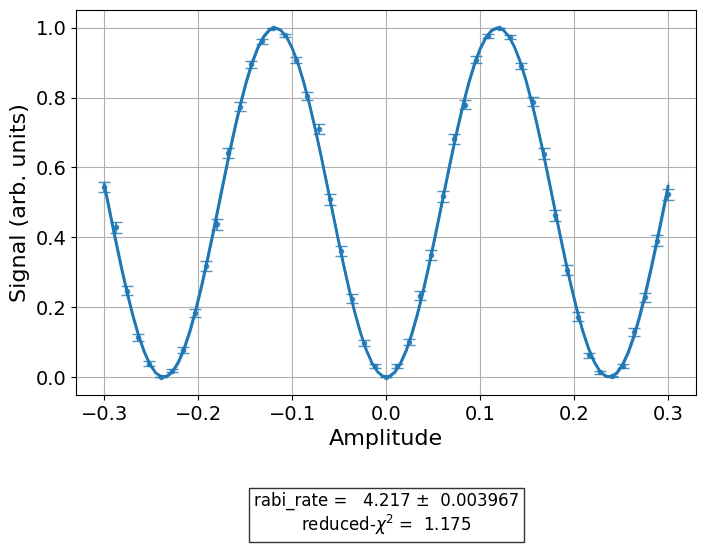

In [41]:
from qiskit_experiments.library import RoughXSXAmplitudeCal

exp_q0 = RoughXSXAmplitudeCal(
    physical_qubits=(0,),
    calibrations=cals,
    amplitudes=np.linspace(-0.3, 0.3, 51), 
    backend=backend,
)
exp_q0.set_run_options(meas_level=2)
exp_data = exp_q0.run().block_for_results()

exp_data.figure(0)

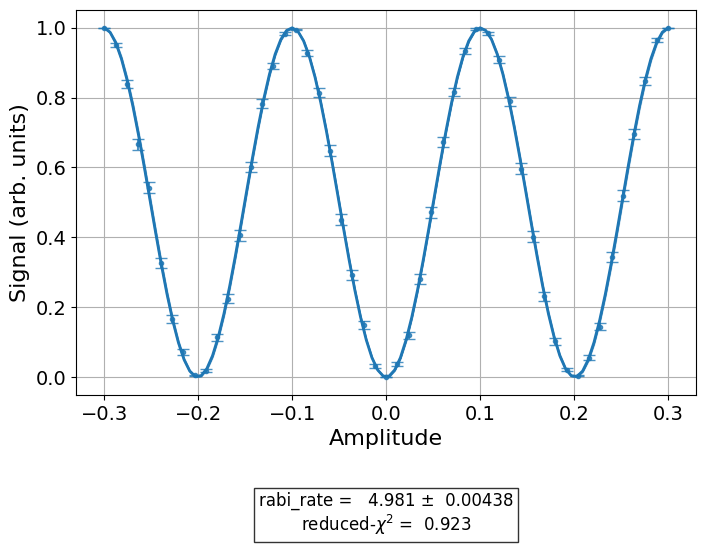

In [42]:
exp_q1 = RoughXSXAmplitudeCal(
    physical_qubits=(1,),
    calibrations=cals,
    amplitudes=np.linspace(-0.3, 0.3, 51), 
    backend=backend,
)
exp_q1.set_run_options(meas_level=2)
exp_data = exp_q1.run().block_for_results()

exp_data.figure(0)

In [44]:
from qiskit_experiments.calibration_management import Calibrations


ecr_amp1 = Parameter("amp")
x_amp1 = cals.get_parameter_value("amp", (0,), "x")
x_amp2 = cals.get_parameter_value("amp", (1,), "x")
with pulse.build(name="ecr", default_alignment="sequential") as ecr_tmp_01:
    pulse.play(
        pulse.GaussianSquare(800, ecr_amp1, 16, risefall_sigma_ratio=2,limit_amplitude=False),##original = 800
        pulse.ControlChannel(0),
    )
    pulse.play(pulse.Gaussian(64, x_amp1, 16,limit_amplitude=True), pulse.DriveChannel(0)) ##original = 160
    pulse.play(
        pulse.GaussianSquare(800, ecr_amp1, 16, risefall_sigma_ratio=2, angle=np.pi,limit_amplitude=False), ##original = 800
        pulse.ControlChannel(0),
    )    
cals.add_schedule(schedule=ecr_tmp_01, qubits=(0, 1))
cals.add_parameter_value(0.2, "amp", (0, 1), "ecr")


In [46]:
x_sched_q0 = cals.get_schedule("x", (0,))
sx_sched_q0 = cals.get_schedule("sx", (0,))
x_sched_q1 = cals.get_schedule("x", (1,))
sx_sched_q1 = cals.get_schedule("sx", (1,))

ecr_sched_q0_q1 = cals.get_schedule("ecr", (0, 1))


backend.target.update_instruction_properties(
    instruction="x",
    qargs=(0,),
    properties=InstructionProperties(
        duration=x_sched_q0.duration * backend.dt, 
        calibration=x_sched_q0,
    ),
)

backend.target.update_instruction_properties(
    instruction="sx",
    qargs=(0,),
    properties=InstructionProperties(
        duration=sx_sched_q0.duration * backend.dt, 
        calibration=sx_sched_q0,
    ),
)


backend.target.update_instruction_properties(
    instruction="x",
    qargs=(1,),
    properties=InstructionProperties(
        duration=x_sched_q1.duration * backend.dt, 
        calibration=x_sched_q1,
    ),
)

backend.target.update_instruction_properties(
    instruction="sx",
    qargs=(1,),
    properties=InstructionProperties(
        duration=sx_sched_q1.duration * backend.dt, 
        calibration=sx_sched_q1,
    ),
)


backend.target.update_instruction_properties(
    instruction="ecr",
    qargs=(0, 1),
    properties=InstructionProperties(
        duration=ecr_sched_q0_q1.duration * backend.dt, 
        calibration=ecr_sched_q0_q1,
    ),
)


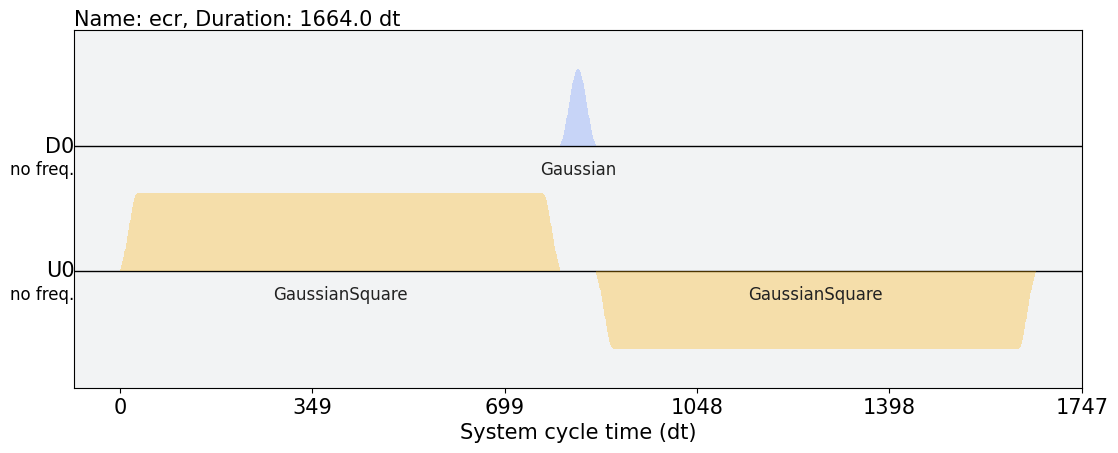

In [237]:
ecr_sched_q0_q1.draw()

In [47]:
from qiskit_experiments.library.calibration.rough_amplitude_cal import CrossResRoughAmplitudeCal

/home/jaewon/jw/lib/python3.8/site-packages/lmfit/minimizer.py:859: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/home/jaewon/jw/lib/python3.8/site-packages/lmfit/minimizer.py:866: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/home/jaewon/jw/lib/python3.8/site-packages/numpy/lib/function_base.py:2412: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


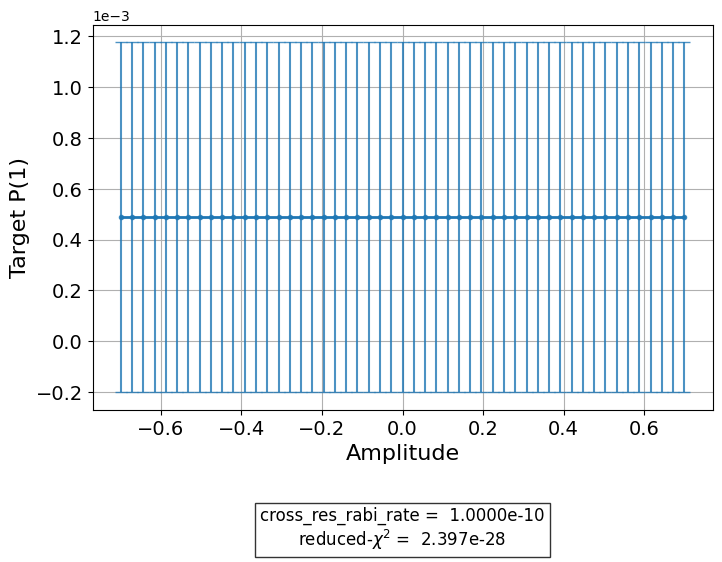

In [48]:
# There is a error in CrossResRpughAmplitudeCal like below
exp = CrossResRoughAmplitudeCal(
    physical_qubits=(0, 1),
    calibrations=cals, 
    backend=backend,
)
exp_data = exp.run().block_for_results()
exp_data.figure(0)


In [235]:
cals.add_parameter_value(0.9,"amp", (0,2), "ecr")

In [49]:
exp_data

ExperimentData(CrossResRoughAmplitudeCal, 556fcd51-b56e-46ef-a7d8-2ad8db7b5b32, job_ids=['efe3b007-f783-4942-8c6a-a90ccf71db36'], metadata=<8 items>, figure_names=['CrossResRoughAmplitudeCal_Fig-0_Exp-556fcd51.svg'])

In [90]:
# Our custom calibration for ecr gate, simply sweeping the amplitude of ecr
def update(amp):
    cals.add_parameter_value(amp, "amp", (0,1), "ecr")
    
    x_sched_q0 = cals.get_schedule("x", (0,))
    sx_sched_q0 = cals.get_schedule("sx", (0,))
    x_sched_q1 = cals.get_schedule("x", (1,))
    sx_sched_q1 = cals.get_schedule("sx", (1,))


    ecr_sched_q0_q1 = cals.get_schedule("ecr", (0, 1))



    backend.target.update_instruction_properties(
        instruction="x",
        qargs=(0,),
        properties=InstructionProperties(
            duration=x_sched_q0.duration * backend.dt, 
            calibration=x_sched_q0,
        ),
    )

    backend.target.update_instruction_properties(
        instruction="sx",
        qargs=(0,),
        properties=InstructionProperties(
            duration=sx_sched_q0.duration * backend.dt, 
            calibration=sx_sched_q0,
        ),
    )


    backend.target.update_instruction_properties(
        instruction="x",
        qargs=(1,),
        properties=InstructionProperties(
            duration=x_sched_q1.duration * backend.dt, 
            calibration=x_sched_q1,
        ),
    )

    backend.target.update_instruction_properties(
        instruction="sx",
        qargs=(1,),
        properties=InstructionProperties(
            duration=sx_sched_q1.duration * backend.dt, 
            calibration=sx_sched_q1,
        ),
    )



    backend.target.update_instruction_properties(
        instruction="ecr",
        qargs=(0, 1),
        properties=InstructionProperties(
            duration=ecr_sched_q0_q1.duration * backend.dt, 
            calibration=ecr_sched_q0_q1,
        ),

    )

In [112]:
# update the calibrated result to backend
x_sched_q0 = cals.get_schedule("x", (0,))
sx_sched_q0 = cals.get_schedule("sx", (0,))
x_sched_q1 = cals.get_schedule("x", (1,))
sx_sched_q1 = cals.get_schedule("sx", (1,))


ecr_sched_q0_q1 = cals.get_schedule("ecr", (0, 1))



backend.target.update_instruction_properties(
    instruction="x",
    qargs=(0,),
    properties=InstructionProperties(
        duration=x_sched_q0.duration * backend.dt, 
        calibration=x_sched_q0,
    ),
)

backend.target.update_instruction_properties(
    instruction="sx",
    qargs=(0,),
    properties=InstructionProperties(
        duration=sx_sched_q0.duration * backend.dt, 
        calibration=sx_sched_q0,
    ),
)


backend.target.update_instruction_properties(
    instruction="x",
    qargs=(1,),
    properties=InstructionProperties(
        duration=x_sched_q1.duration * backend.dt, 
        calibration=x_sched_q1,
    ),
)

backend.target.update_instruction_properties(
    instruction="sx",
    qargs=(1,),
    properties=InstructionProperties(
        duration=sx_sched_q1.duration * backend.dt, 
        calibration=sx_sched_q1,
    ),
)



backend.target.update_instruction_properties(
    instruction="ecr",
    qargs=(0, 1),
    properties=InstructionProperties(
        duration=ecr_sched_q0_q1.duration * backend.dt, 
        calibration=ecr_sched_q0_q1,
    ))

In [56]:
# bell state construction
from qiskit import QuantumCircuit, transpile
qc = QuantumCircuit(2)
qc.x(0)
qc.cx(0,1)
#qc.cx(0,2)
qc.measure_all()
qc.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ X ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

In [103]:
v = dict()
for amp in range(500,600):
    print(amp)
    amp = amp/1000
    update(amp)
    transpiled_qc = transpile(qc, target=target)
    result = backend.run(transpiled_qc,shots =10000).result()
    v[amp] = result.get_counts()

500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599


In [108]:
v

{0.5: {'00': 4035, '01': 4344, '10': 779, '11': 842},
 0.501: {'00': 4180, '01': 4694, '10': 558, '11': 568},
 0.502: {'00': 4153, '01': 5055, '10': 350, '11': 442},
 0.503: {'00': 4186, '01': 5347, '10': 158, '11': 309},
 0.504: {'00': 4001, '01': 5700, '10': 50, '11': 249},
 0.505: {'00': 3882, '01': 5885, '10': 15, '11': 218},
 0.506: {'00': 3696, '01': 6000, '10': 56, '11': 248},
 0.507: {'00': 3478, '01': 6022, '10': 163, '11': 337},
 0.508: {'00': 3304, '01': 5857, '10': 398, '11': 441},
 0.509: {'00': 3019, '01': 5749, '10': 668, '11': 564},
 0.51: {'00': 2812, '01': 5405, '10': 1041, '11': 742},
 0.511: {'00': 2622, '01': 4988, '10': 1433, '11': 957},
 0.512: {'00': 2472, '01': 4489, '10': 1890, '11': 1149},
 0.513: {'00': 2265, '01': 3970, '10': 2287, '11': 1478},
 0.514: {'00': 1991, '01': 3402, '10': 2861, '11': 1746},
 0.515: {'00': 1733, '01': 2887, '10': 3290, '11': 2090},
 0.516: {'00': 1504, '01': 2328, '10': 3749, '11': 2419},
 0.517: {'00': 1300, '01': 1844, '10': 411

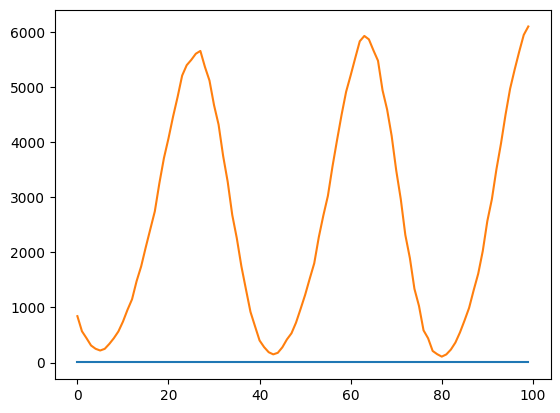

In [110]:
from matplotlib import pyplot as plt
vp = [(i, v[i]['11']) for i in v]
plt.plot(vp)

In [111]:
cals.add_parameter_value(0.6, "amp", (0,1), "ecr")

In [192]:
qc = QuantumCircuit(2)
qc.ecr(0, 1)

exp = ProcessTomography(qc, physical_qubits=(0, 1), backend=backend)
exp.analysis.set_options(fitter="cvxpy_linear_lstsq")
exp_data = exp.run().block_for_results()

In [193]:
exp_data.analysis_results("process_fidelity").value

0.17291896253965072

In [113]:
from qiskit import QuantumCircuit, transpile
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
#qc.cx(0,2)
qc.measure_all()
qc.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

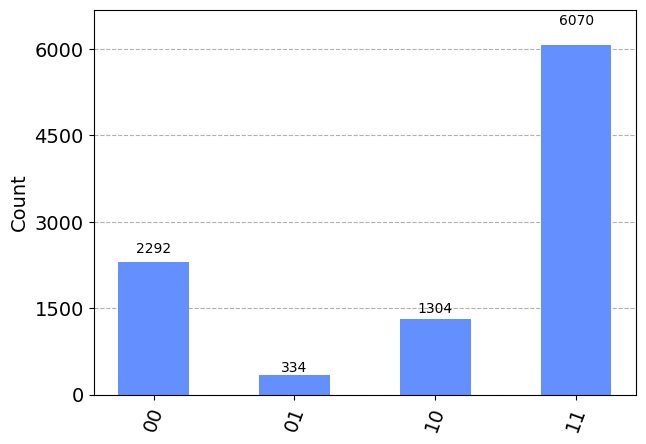

In [71]:
# best parameter from our calibration
transpiled_qc = transpile(qc, target=target)
result = backend.run(transpiled_qc,shots =10000).result()
result.get_counts() 
plot_histogram(result.get_counts())

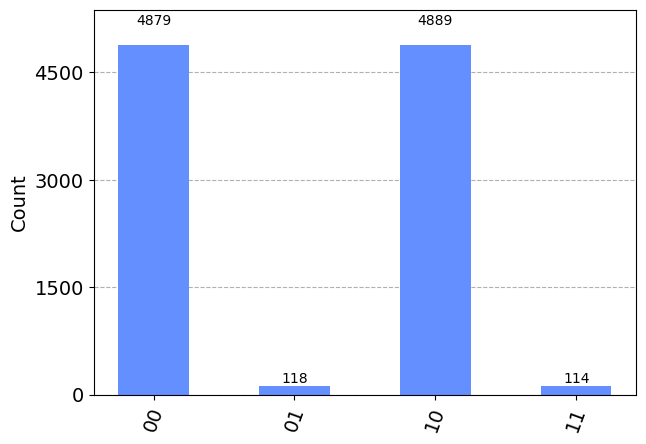

In [95]:
# worst parameter from our calibration, two qubit gate barely worked
transpiled_qc = transpile(qc, target=target)
result = backend.run(transpiled_qc,shots =10000).result()
result.get_counts() 
plot_histogram(result.get_counts())